# 03__hit_gwas

in this notebook, i examine whether our hits have GWAS-associated SNPs in close proximity

figures in this notebook:
- Fig 5C: barplot showing % of hits vs. non-hits with an endo-cancer associated SNP within 5kb

In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import scipy.stats as stats
import seaborn as sns
import sys
import time

from scipy.stats import spearmanr
from scipy.stats import pearsonr
from statsmodels.sandbox.stats import multicomp

# import utils
sys.path.append("../../../utils")
from plotting_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [3]:
index_f = "../../../data/01__design/02__final_sgRNAs/crispri_picked_sgRNAs.not_deduped.txt"

In [4]:
data_f = "../../../data/02__screen/02__enrichment_data/enrichment_values.with_rna_seq.txt"

In [5]:
# all gwas files
gwas_dir = "../../../misc/06__gwas"
closest_gwas_f = "%s/tss_coords.closest_gwas_snp.with_DIGIT.bed" % gwas_dir
closest_cancer_f = "%s/tss_coords.closest_all_cancer_snp.with_DIGIT.bed" % gwas_dir
closest_endo_f = "%s/tss_coords.closest_endo_cancer_snp.with_DIGIT.bed" % gwas_dir
closest_gwas_gb_f = "%s/transcript_coords.closest_gwas_snp.with_DIGIT.bed" % gwas_dir
closest_cancer_gb_f = "%s/transcript_coords.closest_all_cancer_snp.with_DIGIT.bed" % gwas_dir
closest_endo_gb_f = "%s/transcript_coords.closest_endo_cancer_snp.with_DIGIT.bed" % gwas_dir

## 1. import data

In [6]:
index = pd.read_table(index_f)
index.head()

,sgRNA,tss_id,transcript_id,transcript_name,gene_id,gene_name,tss_type,cage_id,sgRNA_qual,cut_offset,rank
0,TTACCTTGGAGAAGAAATGG,NC_000001.11:+:100894913,ENST00000609247.1_1,RP4-549L20.3-001,ENSG00000273204.1_1,RP4-549L20.3,FANTOM CAT assignment,"chr1:101360463..101360478,+",good,42.0,1.0
1,ATGTTTAAAAGTTGTTACCT,NC_000001.11:+:100894913,ENST00000609247.1_1,RP4-549L20.3-001,ENSG00000273204.1_1,RP4-549L20.3,FANTOM CAT assignment,"chr1:101360463..101360478,+",good,56.0,2.0
2,TTTCCTCCATTTCTTCTCCA,NC_000001.11:+:100894913,ENST00000609247.1_1,RP4-549L20.3-001,ENSG00000273204.1_1,RP4-549L20.3,FANTOM CAT assignment,"chr1:101360463..101360478,+",good,50.0,3.0
3,GAAGAAATGGAGGAAAGGAT,NC_000001.11:+:100894913,ENST00000609247.1_1,RP4-549L20.3-001,ENSG00000273204.1_1,RP4-549L20.3,FANTOM CAT assignment,"chr1:101360463..101360478,+",good,32.0,4.0
4,TTGGAGAAGAAATGGAGGAA,NC_000001.11:+:100894913,ENST00000609247.1_1,RP4-549L20.3-001,ENSG00000273204.1_1,RP4-549L20.3,FANTOM CAT assignment,"chr1:101360463..101360478,+",good,37.0,5.0


In [7]:
data = pd.read_table(data_f)
data.head()

,group_id,ctrl_status,endo_ctrl_val,gene_name,gene_id,transcript_name,transcript_id,cleaner_transcript_biotype,cleaner_gene_biotype,BFP+_score__rep1,...,combined_pval,padj,neg_log_padj,is_hit,csf,hESC_mean,endo_mean,qval_hESC_endo,endo_hESC_log2fc,endo_hESC_abslog2fc
0,NC_000008.11:+:54457934,control,True,SOX17,ENSG00000164736.5_1,SOX17-001,ENST00000297316.4_1,protein_coding,protein_coding,232.279434,...,0.000002,0.000284,3.546586,stringent hit,protein_coding,0.110290,134.426513,0.000991006472787698,6.930430,6.930430
1,NC_000003.12:-:27722707,control,True,EOMES,ENSG00000163508.12_1,EOMES-004,ENST00000461503.2_1,protein_coding,protein_coding,156.570722,...,0.000002,0.000284,3.546586,stringent hit,protein_coding,0.123413,101.207791,0.0217931946808208,6.507473,6.507473
2,NC_000003.12:-:27722322,control,True,EOMES,ENSG00000163508.12_1,EOMES-001,ENST00000295743.8_1,protein_coding,protein_coding,43.594914,...,0.000002,0.000284,3.546586,stringent hit,protein_coding,0.084601,85.188250,0.000510199113682609,6.312255,6.312255
3,NC_000016.10:+:23452748,experimental,False,CTD-2270L9.4,ENSG00000260136.5_1,CTD-2270L9.4-001,ENST00000570080.1_1,promoter_overlap,promoter_overlap,3.702626,...,0.000173,0.009619,2.016871,stringent hit,lncRNA_good_csf,1.391981,2.482487,0.0347336116955254,0.541912,0.541912
4,NC_000016.10:+:23452748,experimental,False,CTD-2270L9.4,ENSG00000260136.5_1,CTD-2270L9.4-002,ENST00000562842.1_1,promoter_overlap,promoter_overlap,3.702626,...,0.000173,0.009619,2.016871,stringent hit,lncRNA_good_csf,0.602179,1.020428,0.191063464740555,0.334626,0.334626


In [8]:
closest_gwas = pd.read_table(closest_gwas_f, sep="\t", header=None)
closest_gwas.columns = ["chr", "start", "end", "transcript_id", "score", "strand", "snp_chr", "snp_start", "snp_end",
                        "snp_id", "disease", "distance"]
closest_gwas.head()

,chr,start,end,transcript_id,score,strand,snp_chr,snp_start,snp_end,snp_id,disease,distance
0,chr1,29554,29555,ENST00000473358.1_1,0,+,chr1,780396,780397,rs141175086,circadian rhythm,750842
1,chr1,36072,36073,ENST00000461467.1_1,0,-,chr1,780396,780397,rs141175086,circadian rhythm,744324
2,chr1,91104,91105,ENST00000495576.1_1,0,-,chr1,780396,780397,rs141175086,circadian rhythm,689292
3,chr1,120931,120932,ENST00000466430.5_1,0,-,chr1,780396,780397,rs141175086,circadian rhythm,659465
4,chr1,133565,133566,ENST00000453576.2_1,0,-,chr1,780396,780397,rs141175086,circadian rhythm,646831


In [9]:
closest_cancer = pd.read_table(closest_cancer_f, sep="\t", header=None)
closest_cancer.columns = ["chr", "start", "end", "transcript_id", "score", "strand", "snp_chr", "snp_start", "snp_end",
                        "snp_id", "disease", "distance"]
closest_cancer.head()

,chr,start,end,transcript_id,score,strand,snp_chr,snp_start,snp_end,snp_id,disease,distance
0,chr1,29554,29555,ENST00000473358.1_1,0,+,chr1,894572,894573,rs13303010,pancreatic carcinoma,865018
1,chr1,36072,36073,ENST00000461467.1_1,0,-,chr1,894572,894573,rs13303010,pancreatic carcinoma,858500
2,chr1,91104,91105,ENST00000495576.1_1,0,-,chr1,894572,894573,rs13303010,pancreatic carcinoma,803468
3,chr1,120931,120932,ENST00000466430.5_1,0,-,chr1,894572,894573,rs13303010,pancreatic carcinoma,773641
4,chr1,133565,133566,ENST00000453576.2_1,0,-,chr1,894572,894573,rs13303010,pancreatic carcinoma,761007


In [10]:
closest_endo = pd.read_table(closest_endo_f, sep="\t", header=None)
closest_endo.columns = ["chr", "start", "end", "transcript_id", "score", "strand", "snp_chr", "snp_start", "snp_end",
                        "snp_id", "disease", "distance"]
closest_endo.head()

,chr,start,end,transcript_id,score,strand,snp_chr,snp_start,snp_end,snp_id,disease,distance
0,chr1,29554,29555,ENST00000473358.1_1,0,+,chr1,894572,894573,rs13303010,pancreatic carcinoma,865018
1,chr1,36072,36073,ENST00000461467.1_1,0,-,chr1,894572,894573,rs13303010,pancreatic carcinoma,858500
2,chr1,91104,91105,ENST00000495576.1_1,0,-,chr1,894572,894573,rs13303010,pancreatic carcinoma,803468
3,chr1,120931,120932,ENST00000466430.5_1,0,-,chr1,894572,894573,rs13303010,pancreatic carcinoma,773641
4,chr1,133565,133566,ENST00000453576.2_1,0,-,chr1,894572,894573,rs13303010,pancreatic carcinoma,761007


In [11]:
closest_gwas_gb = pd.read_table(closest_gwas_gb_f, sep="\t", header=None)
closest_gwas_gb.columns = ["chr", "start", "end", "transcript_id", "snp_chr", "snp_start", "snp_end",
                        "snp_id", "disease", "distance"]
closest_gwas_gb.head()

,chr,start,end,transcript_id,snp_chr,snp_start,snp_end,snp_id,disease,distance
0,chr1,11869,14409,ENST00000456328.2_1,chr1,780396,780397,rs141175086,circadian rhythm,765988
1,chr1,12010,13670,ENST00000450305.2_1,chr1,780396,780397,rs141175086,circadian rhythm,766727
2,chr1,14404,29570,ENST00000488147.1_1,chr1,780396,780397,rs141175086,circadian rhythm,750827
3,chr1,29554,31097,ENST00000473358.1_1,chr1,780396,780397,rs141175086,circadian rhythm,749300
4,chr1,30267,31109,ENST00000469289.1_1,chr1,780396,780397,rs141175086,circadian rhythm,749288


In [12]:
closest_cancer_gb = pd.read_table(closest_cancer_gb_f, sep="\t", header=None)
closest_cancer_gb.columns = ["chr", "start", "end", "transcript_id", "snp_chr", "snp_start", "snp_end",
                        "snp_id", "disease", "distance"]
closest_cancer_gb.head()

,chr,start,end,transcript_id,snp_chr,snp_start,snp_end,snp_id,disease,distance
0,chr1,11869,14409,ENST00000456328.2_1,chr1,894572,894573,rs13303010,pancreatic carcinoma,880164
1,chr1,12010,13670,ENST00000450305.2_1,chr1,894572,894573,rs13303010,pancreatic carcinoma,880903
2,chr1,14404,29570,ENST00000488147.1_1,chr1,894572,894573,rs13303010,pancreatic carcinoma,865003
3,chr1,29554,31097,ENST00000473358.1_1,chr1,894572,894573,rs13303010,pancreatic carcinoma,863476
4,chr1,30267,31109,ENST00000469289.1_1,chr1,894572,894573,rs13303010,pancreatic carcinoma,863464


In [13]:
closest_endo_gb = pd.read_table(closest_endo_gb_f, sep="\t", header=None)
closest_endo_gb.columns = ["chr", "start", "end", "transcript_id", "snp_chr", "snp_start", "snp_end",
                        "snp_id", "disease", "distance"]
closest_endo_gb.head()

,chr,start,end,transcript_id,snp_chr,snp_start,snp_end,snp_id,disease,distance
0,chr1,11869,14409,ENST00000456328.2_1,chr1,894572,894573,rs13303010,pancreatic carcinoma,880164
1,chr1,12010,13670,ENST00000450305.2_1,chr1,894572,894573,rs13303010,pancreatic carcinoma,880903
2,chr1,14404,29570,ENST00000488147.1_1,chr1,894572,894573,rs13303010,pancreatic carcinoma,865003
3,chr1,29554,31097,ENST00000473358.1_1,chr1,894572,894573,rs13303010,pancreatic carcinoma,863476
4,chr1,30267,31109,ENST00000469289.1_1,chr1,894572,894573,rs13303010,pancreatic carcinoma,863464


## 2. join metadata files

In [14]:
closest_gwas = closest_gwas[["transcript_id", "snp_id", "disease", "distance"]].drop_duplicates()
closest_cancer = closest_cancer[["transcript_id", "snp_id", "disease", "distance"]].drop_duplicates()
closest_endo = closest_endo[["transcript_id", "snp_id", "disease", "distance"]].drop_duplicates()

In [15]:
print(len(closest_gwas))
print(len(closest_cancer))
print(len(closest_endo))

14730
13808
13348


In [16]:
meta = closest_gwas.merge(closest_cancer, on="transcript_id", how="left").merge(closest_endo, on="transcript_id", how="left")
len(meta)

16770

In [17]:
meta.columns = ["transcript_id", "closest_all_snp", "closest_all_snp_disease", "closest_all_snp_dist",
                "closest_cancer_snp", "closest_cancer_snp_disease", "closest_cancer_snp_dist", 
                "closest_endo_snp", "closest_endo_snp_disease", "closest_endo_snp_dist"]
meta.head()

,transcript_id,closest_all_snp,closest_all_snp_disease,closest_all_snp_dist,closest_cancer_snp,closest_cancer_snp_disease,closest_cancer_snp_dist,closest_endo_snp,closest_endo_snp_disease,closest_endo_snp_dist
0,ENST00000473358.1_1,rs141175086,circadian rhythm,750842,rs13303010,pancreatic carcinoma,865018,rs13303010,pancreatic carcinoma,865018
1,ENST00000461467.1_1,rs141175086,circadian rhythm,744324,rs13303010,pancreatic carcinoma,858500,rs13303010,pancreatic carcinoma,858500
2,ENST00000495576.1_1,rs141175086,circadian rhythm,689292,rs13303010,pancreatic carcinoma,803468,rs13303010,pancreatic carcinoma,803468
3,ENST00000466430.5_1,rs141175086,circadian rhythm,659465,rs13303010,pancreatic carcinoma,773641,rs13303010,pancreatic carcinoma,773641
4,ENST00000453576.2_1,rs141175086,circadian rhythm,646831,rs13303010,pancreatic carcinoma,761007,rs13303010,pancreatic carcinoma,761007


In [18]:
# some transcripts have duplicate closest snps when there are ties, so drop these (keep first arbitrarily)
meta.drop_duplicates(subset="transcript_id", inplace=True)
print(len(meta))
meta.head()

12946


,transcript_id,closest_all_snp,closest_all_snp_disease,closest_all_snp_dist,closest_cancer_snp,closest_cancer_snp_disease,closest_cancer_snp_dist,closest_endo_snp,closest_endo_snp_disease,closest_endo_snp_dist
0,ENST00000473358.1_1,rs141175086,circadian rhythm,750842,rs13303010,pancreatic carcinoma,865018,rs13303010,pancreatic carcinoma,865018
1,ENST00000461467.1_1,rs141175086,circadian rhythm,744324,rs13303010,pancreatic carcinoma,858500,rs13303010,pancreatic carcinoma,858500
2,ENST00000495576.1_1,rs141175086,circadian rhythm,689292,rs13303010,pancreatic carcinoma,803468,rs13303010,pancreatic carcinoma,803468
3,ENST00000466430.5_1,rs141175086,circadian rhythm,659465,rs13303010,pancreatic carcinoma,773641,rs13303010,pancreatic carcinoma,773641
4,ENST00000453576.2_1,rs141175086,circadian rhythm,646831,rs13303010,pancreatic carcinoma,761007,rs13303010,pancreatic carcinoma,761007


In [19]:
closest_gwas_gb = closest_gwas_gb[["transcript_id", "snp_id", "disease", "distance"]].drop_duplicates()
closest_cancer_gb = closest_cancer_gb[["transcript_id", "snp_id", "disease", "distance"]].drop_duplicates()
closest_endo_gb = closest_endo_gb[["transcript_id", "snp_id", "disease", "distance"]].drop_duplicates()

In [20]:
print(len(closest_gwas_gb))
print(len(closest_cancer_gb))
print(len(closest_endo_gb))

457486
218313
208200


In [21]:
meta = meta.merge(closest_gwas_gb, on="transcript_id", how="left").merge(closest_cancer_gb, on="transcript_id", how="left").merge(closest_endo_gb, on="transcript_id", how="left")
len(meta)

46026

In [22]:
meta.columns = ["transcript_id", "tss_closest_all_snp", "tss_closest_all_snp_disease", "tss_closest_all_snp_dist",
                "tss_closest_cancer_snp", "tss_closest_cancer_snp_disease", "tss_closest_cancer_snp_dist", 
                "tss_closest_endo_snp", "tss_closest_endo_snp_disease", "tss_closest_endo_snp_dist",
                "gb_closest_all_snp", "gb_closest_all_snp_disease", "gb_closest_all_snp_dist",
                "gb_closest_cancer_snp", "gb_closest_cancer_snp_disease", "gb_closest_cancer_snp_dist",
                "gb_closest_endo_snp", "gb_closest_endo_snp_disease", "gb_closest_endo_snp_dist"]
meta.head()

,transcript_id,tss_closest_all_snp,tss_closest_all_snp_disease,tss_closest_all_snp_dist,tss_closest_cancer_snp,tss_closest_cancer_snp_disease,tss_closest_cancer_snp_dist,tss_closest_endo_snp,tss_closest_endo_snp_disease,tss_closest_endo_snp_dist,gb_closest_all_snp,gb_closest_all_snp_disease,gb_closest_all_snp_dist,gb_closest_cancer_snp,gb_closest_cancer_snp_disease,gb_closest_cancer_snp_dist,gb_closest_endo_snp,gb_closest_endo_snp_disease,gb_closest_endo_snp_dist
0,ENST00000473358.1_1,rs141175086,circadian rhythm,750842,rs13303010,pancreatic carcinoma,865018,rs13303010,pancreatic carcinoma,865018,rs141175086,circadian rhythm,749300,rs13303010,pancreatic carcinoma,863476,rs13303010,pancreatic carcinoma,863476
1,ENST00000461467.1_1,rs141175086,circadian rhythm,744324,rs13303010,pancreatic carcinoma,858500,rs13303010,pancreatic carcinoma,858500,rs141175086,circadian rhythm,744324,rs13303010,pancreatic carcinoma,858500,rs13303010,pancreatic carcinoma,858500
2,ENST00000495576.1_1,rs141175086,circadian rhythm,689292,rs13303010,pancreatic carcinoma,803468,rs13303010,pancreatic carcinoma,803468,rs141175086,circadian rhythm,689292,rs13303010,pancreatic carcinoma,803468,rs13303010,pancreatic carcinoma,803468
3,ENST00000466430.5_1,rs141175086,circadian rhythm,659465,rs13303010,pancreatic carcinoma,773641,rs13303010,pancreatic carcinoma,773641,rs141175086,circadian rhythm,659465,rs13303010,pancreatic carcinoma,773641,rs13303010,pancreatic carcinoma,773641
4,ENST00000453576.2_1,rs141175086,circadian rhythm,646831,rs13303010,pancreatic carcinoma,761007,rs13303010,pancreatic carcinoma,761007,rs141175086,circadian rhythm,646831,rs13303010,pancreatic carcinoma,761007,rs13303010,pancreatic carcinoma,761007


In [23]:
# some transcripts have duplicate closest snps when there are ties, so drop these (keep first arbitrarily)
meta.drop_duplicates(subset="transcript_id", inplace=True)
print(len(meta))
meta.head()

12946


,transcript_id,tss_closest_all_snp,tss_closest_all_snp_disease,tss_closest_all_snp_dist,tss_closest_cancer_snp,tss_closest_cancer_snp_disease,tss_closest_cancer_snp_dist,tss_closest_endo_snp,tss_closest_endo_snp_disease,tss_closest_endo_snp_dist,gb_closest_all_snp,gb_closest_all_snp_disease,gb_closest_all_snp_dist,gb_closest_cancer_snp,gb_closest_cancer_snp_disease,gb_closest_cancer_snp_dist,gb_closest_endo_snp,gb_closest_endo_snp_disease,gb_closest_endo_snp_dist
0,ENST00000473358.1_1,rs141175086,circadian rhythm,750842,rs13303010,pancreatic carcinoma,865018,rs13303010,pancreatic carcinoma,865018,rs141175086,circadian rhythm,749300,rs13303010,pancreatic carcinoma,863476,rs13303010,pancreatic carcinoma,863476
1,ENST00000461467.1_1,rs141175086,circadian rhythm,744324,rs13303010,pancreatic carcinoma,858500,rs13303010,pancreatic carcinoma,858500,rs141175086,circadian rhythm,744324,rs13303010,pancreatic carcinoma,858500,rs13303010,pancreatic carcinoma,858500
2,ENST00000495576.1_1,rs141175086,circadian rhythm,689292,rs13303010,pancreatic carcinoma,803468,rs13303010,pancreatic carcinoma,803468,rs141175086,circadian rhythm,689292,rs13303010,pancreatic carcinoma,803468,rs13303010,pancreatic carcinoma,803468
3,ENST00000466430.5_1,rs141175086,circadian rhythm,659465,rs13303010,pancreatic carcinoma,773641,rs13303010,pancreatic carcinoma,773641,rs141175086,circadian rhythm,659465,rs13303010,pancreatic carcinoma,773641,rs13303010,pancreatic carcinoma,773641
4,ENST00000453576.2_1,rs141175086,circadian rhythm,646831,rs13303010,pancreatic carcinoma,761007,rs13303010,pancreatic carcinoma,761007,rs141175086,circadian rhythm,646831,rs13303010,pancreatic carcinoma,761007,rs13303010,pancreatic carcinoma,761007


In [24]:
meta[meta["transcript_id"] == "DIGIT"]

,transcript_id,tss_closest_all_snp,tss_closest_all_snp_disease,tss_closest_all_snp_dist,tss_closest_cancer_snp,tss_closest_cancer_snp_disease,tss_closest_cancer_snp_dist,tss_closest_endo_snp,tss_closest_endo_snp_disease,tss_closest_endo_snp_dist,gb_closest_all_snp,gb_closest_all_snp_disease,gb_closest_all_snp_dist,gb_closest_cancer_snp,gb_closest_cancer_snp_disease,gb_closest_cancer_snp_dist,gb_closest_endo_snp,gb_closest_endo_snp_disease,gb_closest_endo_snp_dist
6682,DIGIT,rs61977111,balding measurement,236,rs34877263,"breast carcinoma, mortality",253846,rs11622887,"response to irinotecan, non-small cell lung ca...",705468,rs61977111,balding measurement,0,rs34877263,"breast carcinoma, mortality",250881,rs11622887,"response to irinotecan, non-small cell lung ca...",702503


## 3. merge metadata w/ hit info

In [25]:
data.is_hit.value_counts()

no hit           11196
lenient hit       1428
stringent hit       73
Name: is_hit, dtype: int64

In [26]:
data = data.merge(meta, on="transcript_id", how="left")
print(len(data))
data.head()

12697


,group_id,ctrl_status,endo_ctrl_val,gene_name,gene_id,transcript_name,transcript_id,cleaner_transcript_biotype,cleaner_gene_biotype,BFP+_score__rep1,...,tss_closest_endo_snp_dist,gb_closest_all_snp,gb_closest_all_snp_disease,gb_closest_all_snp_dist,gb_closest_cancer_snp,gb_closest_cancer_snp_disease,gb_closest_cancer_snp_dist,gb_closest_endo_snp,gb_closest_endo_snp_disease,gb_closest_endo_snp_dist
0,NC_000008.11:+:54457934,control,True,SOX17,ENSG00000164736.5_1,SOX17-001,ENST00000297316.4_1,protein_coding,protein_coding,232.279434,...,125338,rs10958409,brain aneurysm,43405,rs28571765,multiple myeloma,75833,rs188586526,lung carcinoma,122385
1,NC_000003.12:-:27722707,control,True,EOMES,ENSG00000163508.12_1,EOMES-004,ENST00000461503.2_1,protein_coding,protein_coding,156.570722,...,436985,rs3806624,Hodgkins lymphoma,421,rs3806624,Hodgkins lymphoma,421,rs481519,"lung carcinoma, estrogen-receptor negative bre...",430787
2,NC_000003.12:-:27722322,control,True,EOMES,ENSG00000163508.12_1,EOMES-001,ENST00000295743.8_1,protein_coding,protein_coding,43.594914,...,436600,rs2371108,leukocyte count,423,rs3806624,Hodgkins lymphoma,634,rs481519,"lung carcinoma, estrogen-receptor negative bre...",430227
3,NC_000016.10:+:23452748,experimental,False,CTD-2270L9.4,ENSG00000260136.5_1,CTD-2270L9.4-001,ENST00000570080.1_1,promoter_overlap,promoter_overlap,3.702626,...,3075192,rs250585,egg allergy measurement,63004,rs35557655,"estrogen-receptor negative breast cancer, mort...",656660,rs35874699,colorectal cancer,3070353
4,NC_000016.10:+:23452748,experimental,False,CTD-2270L9.4,ENSG00000260136.5_1,CTD-2270L9.4-002,ENST00000562842.1_1,promoter_overlap,promoter_overlap,3.702626,...,3075192,rs250585,egg allergy measurement,63253,rs35557655,"estrogen-receptor negative breast cancer, mort...",656909,rs35874699,colorectal cancer,3070335


In [27]:
data.is_hit.value_counts()

no hit           11196
lenient hit       1428
stringent hit       73
Name: is_hit, dtype: int64

## 4. plots to examine gwas closeness

In [28]:
order = ["lncRNA_good_csf", "protein_coding"]
hue_order = ["no hit", "stringent hit"]
pal = {"no hit": "gray", "lenient hit": sns.color_palette("Set2")[2], "stringent hit": "black"}

In [29]:
hue_order2 = ["no hit", "hit"]
pal2 = {"no hit": "gray", "hit": "black"}

In [30]:
def snp_within_x(row, col, x):
    if row[col] < x:
        return "yes"
    else:
        return "no"

In [31]:
data["gwas_within_5_gb"] = data.apply(snp_within_x, col="gb_closest_all_snp_dist", x=5000, axis=1)
data["cancer_within_5_gb"] = data.apply(snp_within_x, col="gb_closest_cancer_snp_dist", x=5000, axis=1)
data["endo_within_5_gb"] = data.apply(snp_within_x, col="gb_closest_endo_snp_dist", x=5000, axis=1)

0.00232898220262
1.0


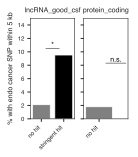

In [33]:
x = 5

for t in ["endo"]:
    fig, axarr = plt.subplots(figsize=(1.75, 1.85), nrows=1, ncols=2, sharey=True)

    for i, csf in enumerate(order):
        ax = axarr[i]
        sub = data[data["csf"] == csf]
        sub = sub[sub["gb_closest_all_snp_dist"] != -1]

        tots = sub.groupby("is_hit")["gene_id"].agg("count").reset_index()
        within_x = sub.groupby(["is_hit", "%s_within_%s_gb" % (t, x)])["gene_id"].agg("count").reset_index()
        within_x = within_x[within_x["%s_within_%s_gb" % (t, x)] == "yes"]
        perc = tots.merge(within_x, on="is_hit", how="left")
        perc["perc"] = (perc["gene_id_y"]/perc["gene_id_x"])*100

        # fisher's exact
        perc["no_enh"] = perc["gene_id_x"] - perc["gene_id_y"]
        table = perc[perc["is_hit"].isin(hue_order)][["is_hit", "no_enh", "gene_id_y"]].set_index("is_hit")
        #print(table)
        table.fillna(0, inplace=True)
        o, p = stats.fisher_exact(table, alternative='greater')
        print(p)


        sns.barplot(data=perc, x="is_hit", y="perc", ax=ax, order=hue_order, palette=pal)

        ax.set_xticklabels(hue_order, rotation=45, ha="right", va="top")
        ax.set_xlabel("")
        ax.set_ylabel("%% with %s cancer SNP within %s kb" % (t, x))
        ax.set_title(csf)
        if i != 0:
            ax.set_ylabel("")
        
        if t == "gwas":
            ax.set_ylim((0, 70))
        elif t == "cancer":
            ax.set_ylim((0, 25))
        else:
            ax.set_ylim((0, 15))
            
        # annotate pval
        max_p = perc["perc"].max()
        annotate_pval(ax, 0.2, 0.8, max_p + 1, 0, max_p + 1, p, fontsize)

        fig.savefig("Fig5C.pdf", dpi="figure", bbox_inches="tight")

## write file

In [34]:
len(meta)

12946

In [35]:
meta.to_csv("../../../data/02__screen/02__enrichment_data/transcript_features.txt", sep="\t", index=False)